### CreditNinja Python Case Study

Problem Statement: Credit Risk Analysis (Predictions of Loan Defaulters)

First things first, necessary imports!

## 1) Data Review and Dependant Variable Definition

In [1]:
# Imports..
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Simple Months Map

In [2]:
MONTHS_MAP = {
                'Jan': 1,
                'Feb': 2,
                'Mar': 3,
                'Apr': 4,
                'May': 5,
                'Jun': 6,
                'Jul': 7,
                'Aug': 8,
                'Sep': 9,
                'Oct': 10,
                'Nov': 11,
                'Dec': 12
             }

#### Get the data to analyze.

In [3]:
def get_data(data_file_path):
    """
    This fucntion should just read the data and return the pandas dataframe.
    :param data_file_path: File path where the date is stored.
    :return: df: Dataframe.
    """

    df = pd.read_csv(data_file_path)
    return df

df = get_data('data.csv')

#### Visualize the class labels.

I consider it as a `Binary Classification` problem since the goal of the analysis is to predict the loan defaulters.

So, I mapped `Fully Paid` and `Current` as the people who are not defaulters.

Clearly, there would not be a lot of people who have defaulted their loan payments. Our objective is to understand who these people are.

0    73963
1     6037
Name: loan_status, dtype: int64


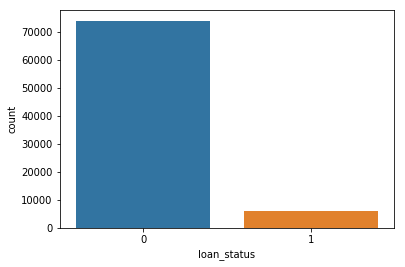

In [4]:
def visualize_class_label(df):
    """
    This function should plot different visualizations of the data.
    :param df: Dataframe
    :return: Mapped Class Label (Just plotting)
    """

    # Class Label Distribution Plot after Mapping
    df['loan_status'] = df['loan_status'].map({'Fully Paid': 0, 'Current': 0, 'Default': 1})
    print(df["loan_status"].value_counts())
    # Class Label Plot
    sns.countplot(df['loan_status'])
    return df

df = visualize_class_label(df)

#### Some minor feature preprocessing.

1) Drop the `id` since it does not contribute to our analysis because of its random nature.

2) Map the `term` feature with `60 months` as just `60` and `36 months` as just `36` to avoid redundancy.

3) Break the `issue_d`, `earliest_cr_line` and `last_credit_pull_d` feature into separate months and years.

In [5]:
# Drop 'ID' column
df = df.drop(columns=['id'])
# Remove the string month from term
df['term'] = df['term'].map({'60 months': 60, '36 months': 36})
# Update 'issue_m' column
def update_month(value):

    if type(value) is float:

        return value

    return MONTHS_MAP[value[:3]]

def update_year(value):

    return int(value[-4:])

df['issue_m'] = df['issue_d'].apply(lambda month_index: update_month(month_index))
df['issue_y'] = df['issue_d'].apply(lambda year: update_year(year))
# Update 'earliest_cr_line' column
df['earliest_cr_line_m'] = df['earliest_cr_line'].apply(lambda month_index: update_month(month_index))
def update_cr_line_year(value):

    if type(value) is float:

        return value

    year = int(value[-2:])
    if year > 19:

        year += 1900
    else:

        year += 2000

    return year

df['earliest_cr_line_y'] = df['earliest_cr_line'].apply(lambda year: update_cr_line_year(year))
# Update 'emp_length' column
def update_emp_length(duration):

    if duration == np.nan or duration == 'n/a':

        return np.nan

    if duration == "< 1 year":

        return int(0)

    elif duration == "10+ years":

        return int(10)

    elif type(duration) == str:

        return int(duration[0])

    else:

        return duration

df['emp_length'] = df['emp_length'].apply(lambda duration: update_emp_length(duration))
# Update 'last_credit_pull_d' column
df['last_credit_pull_m'] = df['last_credit_pull_d'].apply(lambda month_index: update_month(month_index))
df['last_credit_pull_y'] = df['last_credit_pull_d'].apply(lambda year: update_cr_line_year(year))
# Drop the updated columns
df = df.drop(columns=['issue_d', 'last_credit_pull_d', 'earliest_cr_line'])

#### Map the states with geographic region to identify business value.

Based on which part the state appears on the US map, they have been mapped with the following:

`west_side`

`south_west`

`south_east`

`mid_west`

`north_east`

In [6]:
df['addr_state'].unique()

# Divide the states by their geographic region
geography_map = {
                    'west_side': ['CA', 'OR', 'UT', 'WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID'],
                    'south_west': ['AZ', 'TX', 'NM', 'OK'],
                    'south_east': ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN'],
                    'mid_west': ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND'],
                    'north_east': ['CT', 'NY', 'PA', 'NJ', 'RI', 'MA', 'MD', 'VT', 'NH', 'ME']
                }
df['geographic_part'] = np.nan
def map_state(state):

    """
    This function should map the state with the geographic part.
    :param state: US State
    :return: geographic_area
    """

    for geographic_part, states in geography_map.items():

        if state in states:

            return geographic_part


df['geographic_part'] = df['addr_state'].apply(lambda state: map_state(state))

#### Function to display the Point Plots of a target feature with respect to the loan amounts.

In [7]:
def point_plot(df, feature):
    """
    This function should plot the point plot
    :param df: Dataframe
    :param labels: The labels of the parts
    :param feature: Column to plot the point plot
    :return: None (Just plotting)
    """

    plt.figure(figsize=(15, 7))
    g = sns.pointplot(
                      x=feature,
                      y='loan_amnt',
                      data=df,
                      hue='loan_status',
                      join=True,
                      colors=["g", "r"],
                      markers=['o', 'x'],
                      linestyles=['--', '-']
                      )
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    g.set_xlabel("{}".format(feature.upper()), fontsize=15)
    g.set_ylabel("Loan Amount", fontsize=15)
    g.legend(loc='best')
    g.set_title("Distribution of {} by Loan Defaulters".format(feature.upper()), fontsize=20)
    plt.show()

#### Function to display the Dist Plots of a target feature.

In [8]:
def dist_plot(df, feature):
    """
    This function shoul plot the distplot.
    :param df: Dataframe
    :param feature: Column to be plotted
    :return: None (Just Plotting)
    """

    feature_values = df[feature].values
    plt.figure(figsize=(10, 5))
    sns.distplot(feature_values, color='red')
    plt.title("{} Distribution".format(feature.upper()))
    plt.xlabel("{}".format(feature.upper()))
    plt.ylabel("Number")

#### Function to display the Dist Plots of a target feature.

In [9]:
def count_plot(df, feature):
    """
    This function should plot the count plot.
    :param df: Dataframe
    :param feature: Column to be plotted on.
    :return: None (Just Plotting)
    """

    plt.figure(figsize=(15, 5))
    plt.tight_layout()
    sns.countplot(df[feature])
    plt.title('{} Distribution Count Plot'.format(feature.upper()))

#### Visual representation of the Safe and Risky customers.

Clearly, there are only 7.55 % risky customers in the dataset.

Text(0.5, 1.0, 'Loan Defaulters Distribution')

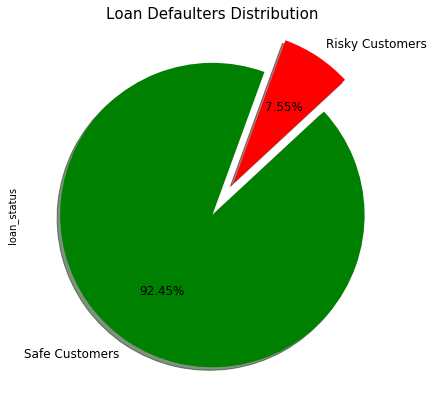

In [10]:
# Pie Chart for the Safe and Risky Customers
labels = "Safe Customers", "Risky Customers"
plt.figure(figsize=(7, 7))
df["loan_status"].value_counts().plot.pie(explode=[0, 0.25],
                                          autopct='%1.2f%%',
                                          shadow=True,
                                          colors=["green", "red"],
                                          labels=labels,
                                          fontsize=12,
                                          startangle=70)
plt.title('Loan Defaulters Distribution', fontsize=15)

#### Dist Plots of some important features.

Key Observation:

1) Most of the loan amounts taken were below 20,000 USD.

2) Most of the planned installments lie below 700 USD.

3) Majority of the customers worked for 10 or more years below taking the loan.

C:\Users\SRIRAM VETURI\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\SRIRAM VETURI\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\SRIRAM VETURI\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


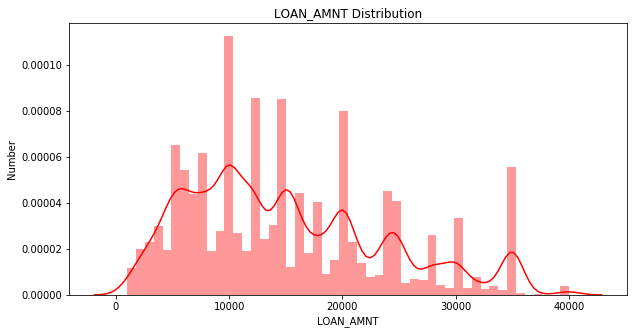

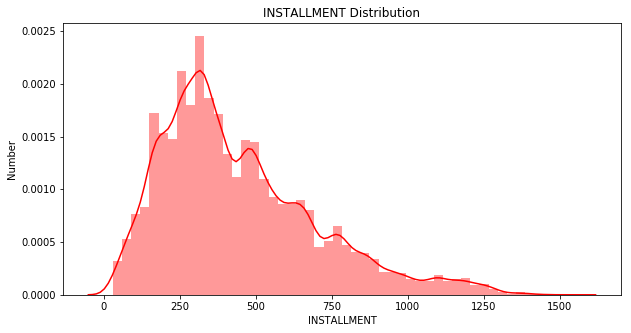

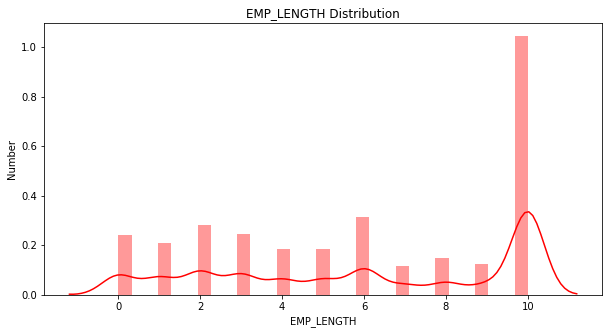

In [11]:
df["emp_length"] = df["emp_length"].fillna(df["emp_length"].mean())
dist_plot_features = ['loan_amnt', 'installment', 'emp_length']
for target_feature in dist_plot_features:

    dist_plot(df, target_feature)

#### Distribution of the issue month of Safe and Risky Customers with respect to the loan amount.

The loans that were issued in May and August have highest number of defaulters and January had lowest number of defaulters.

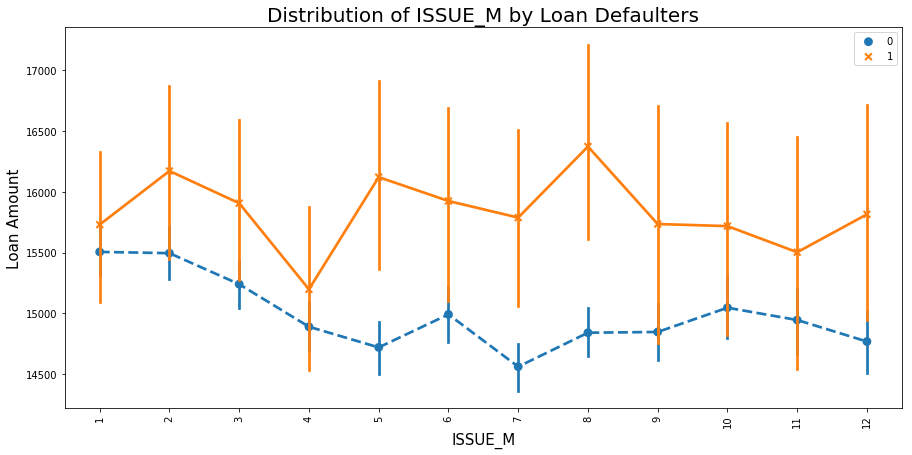

In [12]:
target_feature = 'issue_m'
point_plot(df, target_feature)

#### Distribution of the loan taking purpose of Safe and Risky Customers with respect to the loan amount.

Surprisingly, the loans took for the `welding` purpose had no defaulters at all.

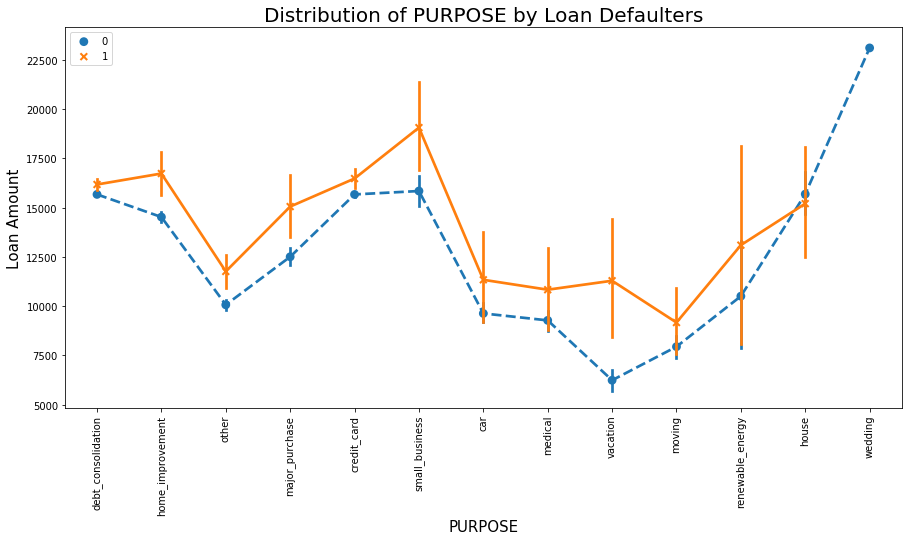

In [13]:
target_feature = 'purpose'
point_plot(df, target_feature)

#### Distribution of the geographic region of Safe and Risky Customers with respect to the loan amount.

Clearly, `midwest` is the best part for the banks since they have defaulters with lowest loan amount.

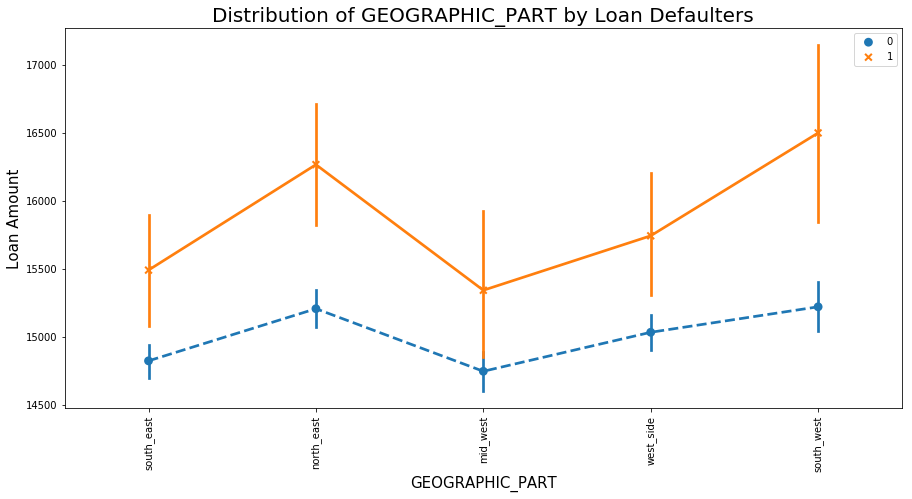

In [14]:
target_feature = 'geographic_part'
point_plot(df, target_feature)

#### Distribution of the state of Safe and Risky Customers with respect to the loan amount.

Clearly, `Idaho` is definitely not a state to expand business since it had defaulters with highest loan amount than any other state. 

That's a huge loss happening in `Idaho`.

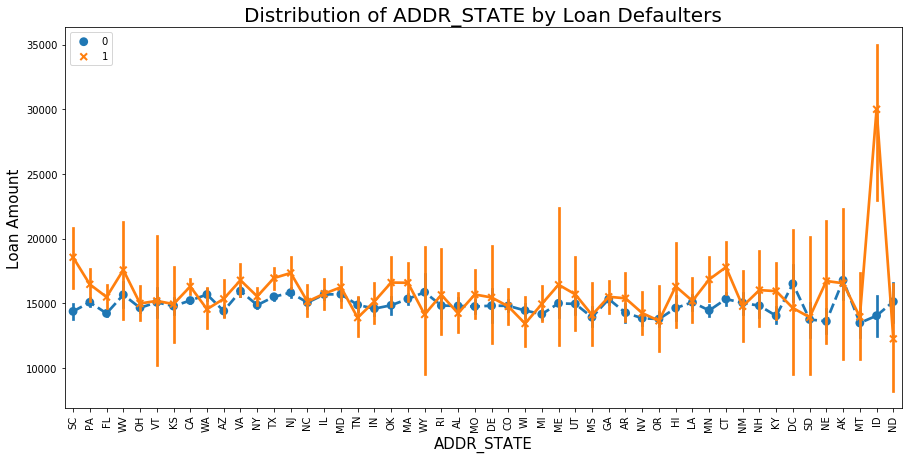

In [15]:
target_feature = 'addr_state'
point_plot(df, target_feature)

#### Distribution of the loan term of Safe and Risky Customers with respect to the loan amount.

No conclusoins could be made out of this since they have identical plots.

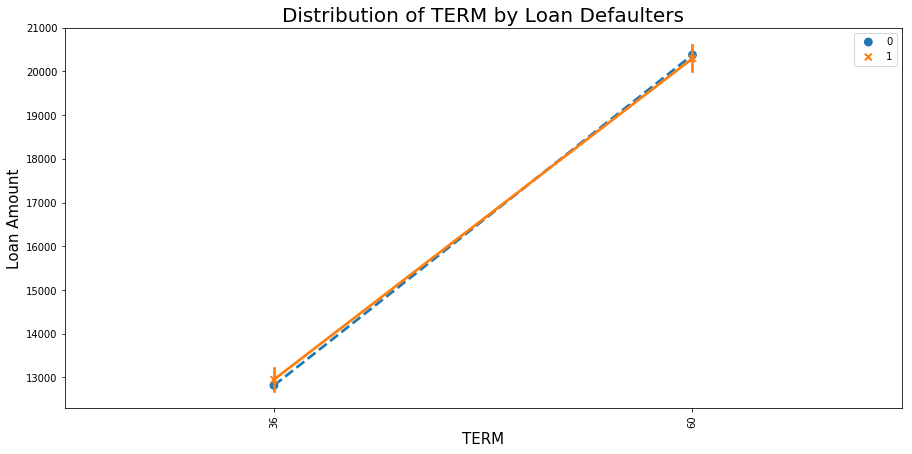

In [16]:
target_feature = 'term'
point_plot(df, target_feature)

#### Distribution of the verification status of Safe and Risky Customers with respect to the loan amount.

Clearly, they have a downward trend which obvious. People with `Not Verified` status would go for lower amount of loan.

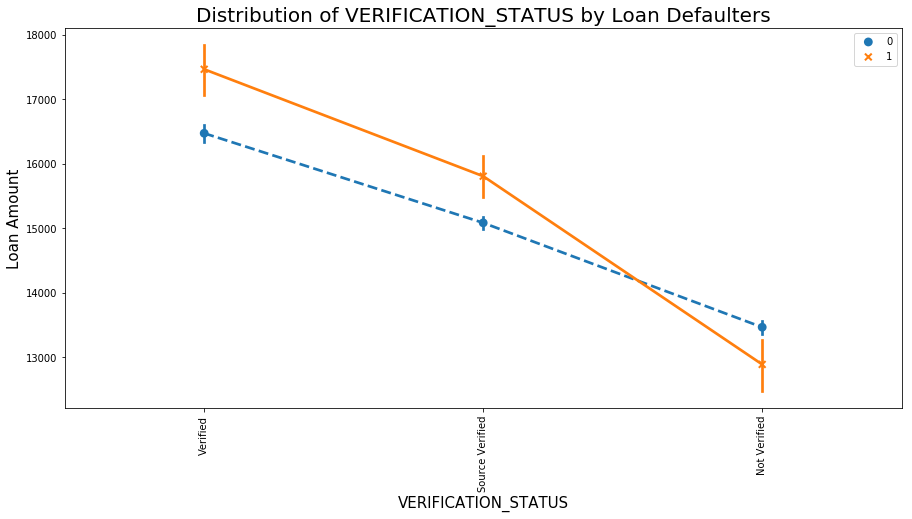

In [17]:
target_feature = 'verification_status'
point_plot(df, target_feature)

#### Distribution of the income of Safe and Risky Customers with respect to the loan amount.

The incomes of the customers have been grouped into different windows.

Surprisingly, people with income close to `120000 USD` took higher amount of loans compared to people with incomes more than `120000 USD`

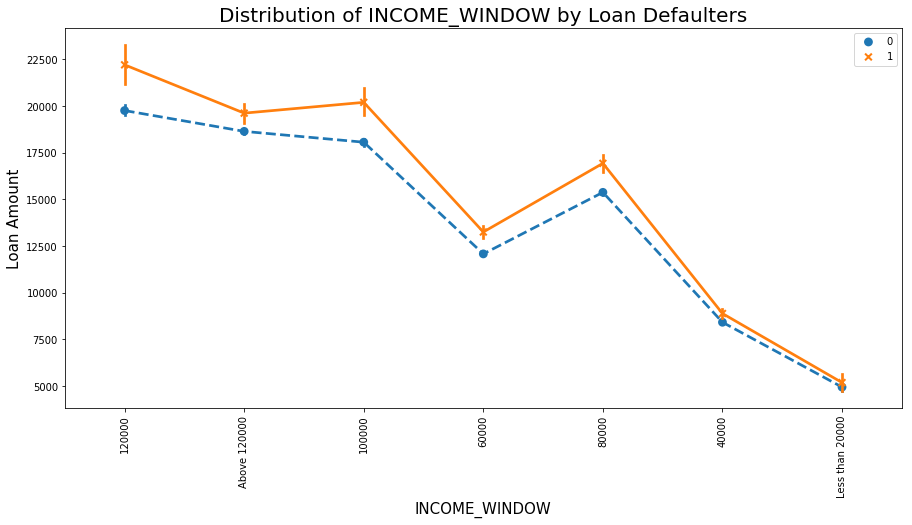

In [18]:
def get_window(income):
    if income < 20000:
        return 'Less than 20000'
    elif 20000 < income < 40000:
        return '40000'
    elif 40000 < income < 60000:
        return '60000'
    elif 60000 < income < 80000:
        return '80000'
    elif 80000 < income < 100000:
        return '100000'
    elif 100000 < income < 120000:
        return '120000'
    else:
        return 'Above 120000'
df['income_window'] = df['annual_inc'].apply(lambda x: get_window(x))
target_feature = 'income_window'
point_plot(df, target_feature)
df = df.drop(columns=['income_window'])

#### Distribution of the employment length of Safe and Risky Customers with respect to the loan amount.

The graphs have zig-zag pattern. So, can't really make much out of this plot.

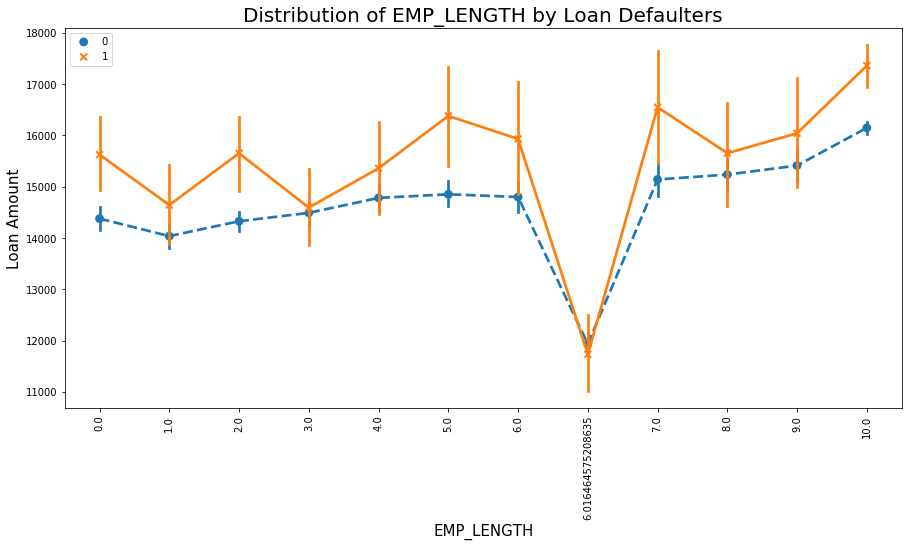

In [19]:
target_feature = 'emp_length'
point_plot(df, target_feature)

#### Distribution of the installment window of Safe and Risky Customers with respect to the loan amount.

The graphs have zig-zag pattern. So, can't really make much out of this plot.

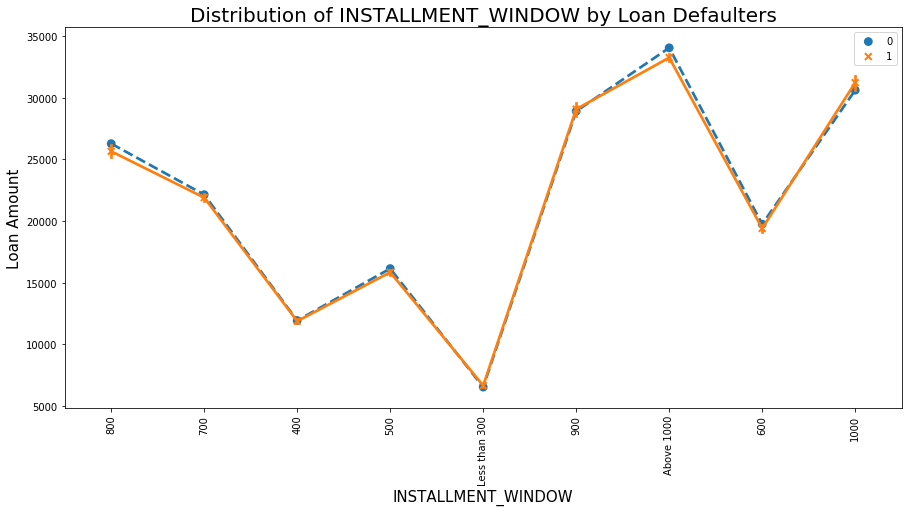

In [20]:
def get_window(installment_amount):
    if installment_amount < 300:
        return 'Less than 300'
    elif 300 < installment_amount < 400:
        return '400'
    elif 400 < installment_amount < 500:
        return '500'
    elif 500 < installment_amount < 600:
        return '600'
    elif 600 < installment_amount < 700:
        return '700'
    elif 700 < installment_amount < 800:
        return '800'
    elif 800 < installment_amount < 900:
        return '900'
    elif 900 < installment_amount < 1000:
        return '1000'
    else:
        return 'Above 1000'
df['installment_window'] = df['installment'].apply(lambda x: get_window(x))
target_feature = 'installment_window'
point_plot(df, target_feature)
df = df.drop(columns=['installment_window'])

#### Count Plot for issue year.

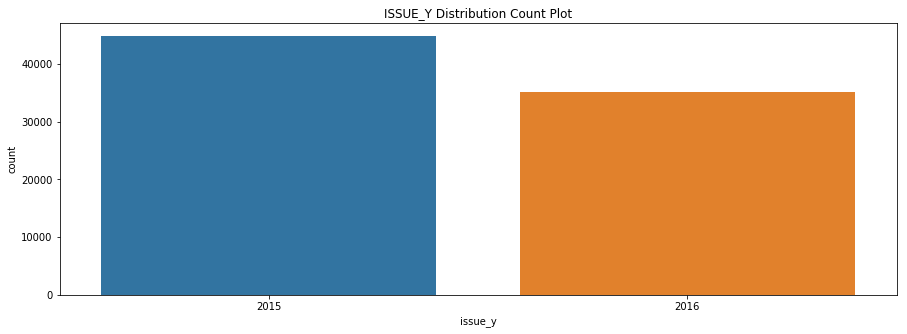

In [21]:
target_feature = 'issue_y'
count_plot(df, target_feature)

#### Count Plot for verification status.

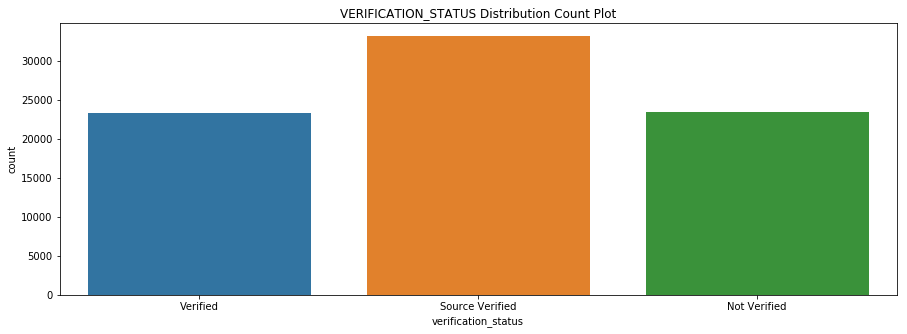

In [22]:
target_feature = 'verification_status'
count_plot(df, target_feature)

#### The number of defaulted loans per state.

Wait, California? It is probably because the population is also high in Califonia compared to other states.

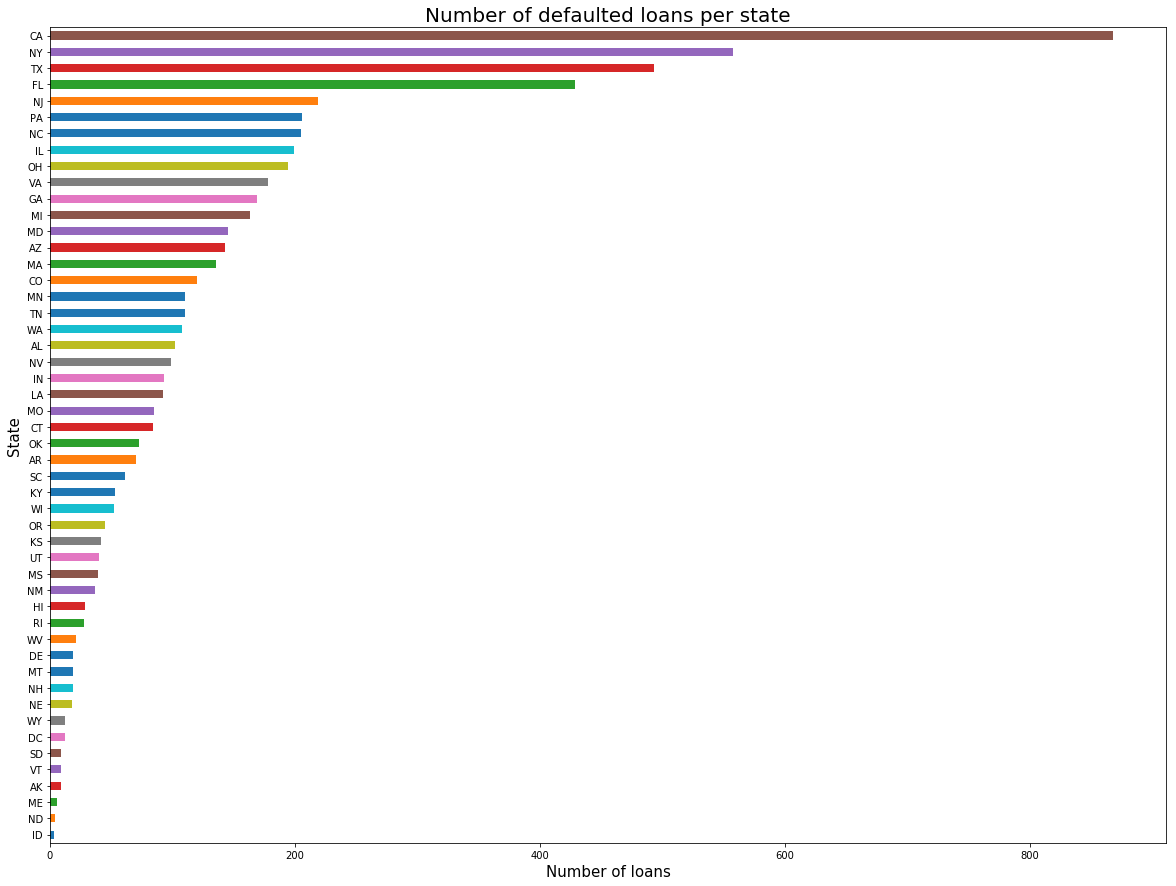

In [23]:
fig = plt.figure(figsize=(20, 15))
df[df['loan_status'] == 1].groupby('addr_state')['loan_status'].count().sort_values().plot(kind='barh')
plt.ylabel('State', fontsize=15)
plt.xlabel('Number of loans', fontsize=15)
plt.title('Number of defaulted loans per state', fontsize=20);

## 2) Data Cleaning

### Feature Selection based on the correlation values.

In [24]:
corr = df.corr()['loan_status'].sort_values()
print("\n\nMost Important Features:")
print(corr.tail(5))
print(corr.head(5))



Most Important Features:
installment       0.032975
inq_last_12m      0.059011
term              0.060356
inq_last_6mths    0.064537
loan_status       1.000000
Name: loan_status, dtype: float64
last_fico_range_high   -0.523442
last_fico_range_low    -0.517777
issue_y                -0.113224
fico_range_low         -0.083696
fico_range_high        -0.083695
Name: loan_status, dtype: float64


#### Fill in the missing values by the most frequent value in the column.

In [25]:
def fill_missing_values(df):
    """
    This function fills in missing values with the column modes.
    :param df: DataFrame
    :return: df: Filled DataFrame
    """
    missing_values_columns = [
                                'mths_since_last_delinq',
                                'mths_since_last_record',
                                'inq_last_6mths',
                                'inq_last_12m',
                                'last_credit_pull_m',
                                'last_credit_pull_y'
                             ]
    for col in missing_values_columns:

        df[col] = df[col].fillna(df[col].mode()[0])

    return df

df = fill_missing_values(df)

#### Encode the categorical features to numbers.

In [26]:
def handle_categorical_data(df):
    """
    This function encodes the categorcial features of the dataset.
    :param df: DataFrame
    :return: df: Encoded DataFrame
    """

    # Preprocess categorical columns
    catData = df.select_dtypes(include=['object'])
    catColumns = catData.columns
    df = df.drop(columns=catColumns)
    for x in catData.columns:

        uniqueValues = catData[x].unique()
        mapping = dict(zip(uniqueValues, np.arange(float(len(uniqueValues)))))
        catData[x] = catData[x].map(mapping)

    df = pd.concat([df, catData], axis=1)
    return df

df = handle_categorical_data(df)

c:\users\sriram veturi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


#### Standardize/Normalize the dataset

In [27]:
def standardize_dataset(df):
    """
    This function should standardize/normalize the numerical values.
    :param df: DataFrame
    :return: df: Standardized DataFrame
    """

    class_variable = df['loan_status']
    df = df.drop(columns=['loan_status'])
    df_columns = df.columns
    scaler = StandardScaler()
    scaledData = scaler.fit_transform(df)
    df = pd.DataFrame(data=scaledData, columns=df_columns)
    df['loan_status'] = class_variable
    return df

df = standardize_dataset(df)

c:\users\sriram veturi\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\sriram veturi\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### Handle the problem of multi-collinearity.

`fico_range_low` is removed from the dataset. Most educated guess would be because it might have highly correlated with `fico_range_high`.

In [28]:
def remove_multicollinear_features(df):
    """
    This fucntion should drop multicollinear features from the dataset.
    :param df: DataFrame
    :return: df: DataFrame with multicollinear features removed
    """

    print("\n\nChecking for the Multi-Collinear Features.")
    # Source: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-in-python
    def calculate_vif_(X, thresh=100):

        cols = X.columns
        variables = np.arange(X.shape[1])
        dropped = True
        while dropped:

            dropped = False
            c = X[cols[variables]].values
            vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
            maxloc = vif.index(max(vif))
            if max(vif) > thresh:

                print('Dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
                variables = np.delete(variables, maxloc)
                dropped = True

        return X[cols[variables]]

    df = calculate_vif_(df)
    print("Removed Multi-Collinear Features.")
    return df

df = remove_multicollinear_features(df)



Checking for the Multi-Collinear Features.
Dropping 'fico_range_low' at index: 6
Removed Multi-Collinear Features.


## 3) Data Analysis and Modeling

#### Separate features with class labels for machine learning.

In [29]:
def separate_features_and_labels(df):
    """
    This fucntion should separate features and class labels.
    :param df: DataFrame
    :return: Separated Data
    """

    class_label = df['loan_status']
    df = df.drop(columns=['loan_status'])
    df['loan_status'] = class_label
    
separate_features_and_labels(df)

#### Split the dataset into training sets and testing sets.

In [30]:
def split_dataset(dataset):
    """
    This fucntion should split the dataset in to train and test sets
    :param dataset: dataframe
    :return: X_train, X_test, y_train, y_test (Split sets)
    """

    X = dataset.iloc[:,:-1].values
    y = dataset.iloc[:,-1].values
    # Splitting the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.1)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_dataset(df)

### Balance the Dataset

Since the class labels are unbalanced, we should balance them by either `oversampling` or `undersampling`. 

I have done `oversampling` since the dataset is considerably not very huge.

I have used `SMOTE` (Synthetic Minority Over Sampling Technique) for `oversampling` the dataset. 

In [31]:
def balance_dataset(x_train, y_train):
    """
    This function should balance the dataset
    :param x_train: Train Features
    :param y_train: Train Labels
    :return:
    """
    sm = SMOTE(random_state=12, ratio=1.0)
    x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
    return x_train_res, y_train_res

x_train_res, y_train_res = balance_dataset(X_train, y_train)

The size of the training sets have been doubled since minority classes have been added to the original dataset.

In [32]:
x_train_res.shape

(133180, 27)

In [33]:
y_train_res.shape

(133180,)

### Random Forest Evaluations (Base Model)

1) After cross-validation, the best 'n_estimators' was found to be 50. 

2) In this problem, the testing accuracy does not matter since we have to find the minority class.

3) So, the recall score of testing set is `0.67` which is good for a base learner.

In [34]:
print("Random Forest Evaluations")

#************************UNCOMMENT THIS CODE FOR CROSS VALIDATION************************#
print("Cross Validating for best parameters..")
print("This might take some time..\n")
clf_rf = RandomForestClassifier()
estimatorsList = [25, 50]
parameters = {'n_estimators': estimatorsList}
gridSearch = GridSearchCV(estimator=clf_rf,
                          param_grid=parameters,
                          scoring="recall",
                          cv=10,
                          n_jobs=4
                          )
gridSearch.fit(x_train_res, y_train_res)
bestAccuracyLogBestK = gridSearch.best_score_
bestParametersLogBestK = gridSearch.best_params_
print("The best parameters for Random Forest model are :\n{}\n".format(bestParametersLogBestK))

Random Forest Evaluations
Cross Validating for best parameters..
This might take some time..

The best parameters for Random Forest model are :
{'n_estimators': 50}



In [34]:
clf_rf = RandomForestClassifier(n_estimators=50, random_state=12)
clf_rf.fit(x_train_res, y_train_res)
print('\nTrain Results')
print("Training Accuracy: ", clf_rf.score(x_train_res, y_train_res))
print("Training Recall: ", recall_score(y_train_res, clf_rf.predict(x_train_res)))
print('\nTest Results')
print("Testing Accuracy: ", clf_rf.score(X_test, y_test))
predictions = clf_rf.predict(X_test)
print("Testing Recall Score: ", recall_score(y_test, predictions))


Train Results
Training Accuracy:  0.999954948190419
Training Recall:  0.999954948190419

Test Results
Testing Accuracy:  0.944875
Testing Recall Score:  0.671451355661882


#### Random Forest Model ROC Curve.

The area under the curve is 0.82 which is not bad for a base model.

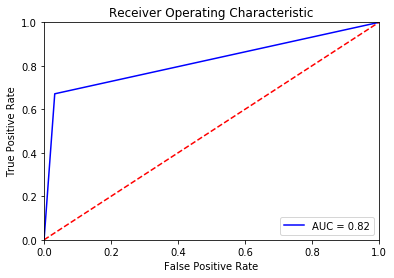

In [35]:
# y_pred = predictions[:, 1]
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest Model Precision-Recall Curve.

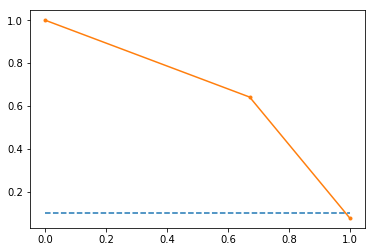

In [36]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
auc = auc(recall, precision)
ap = average_precision_score(y_test, predictions)
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show(True)

### Logistic Regression Evaluations (Main Model)

1) After cross-validation, the best 'C' was found to be 1. 

2) In this problem, the testing accuracy does not matter since we have to find the minority class.

3) So, the recall score of testing set is `0.823` which is a great improvement from our base model.

In [37]:
print("Logistic Regression")
print("Cross Validating for best parameters..")
print("This might take some time..\n")
lr = LogisticRegression()
cList = [0.1, 1, 10]
parameters = {'C': cList}
gridSearch = GridSearchCV(estimator=lr,
                          param_grid=parameters,
                          scoring="recall",
                          cv=10,
                          n_jobs=4)
gridSearch.fit(x_train_res, y_train_res)
bestAccuracyLogBestK = gridSearch.best_score_
bestParametersLogBestK = gridSearch.best_params_
print("The best parameters for Logistic Regression model are :\n{}\n".format(bestParametersLogBestK))

Logistic Regression
Cross Validating for best parameters..
This might take some time..



c:\users\sriram veturi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The best parameters for Logistic Regression model are :
{'C': 1}



In [37]:
lr = LogisticRegression(C=1)
lr.fit(x_train_res, y_train_res)
print('\nTrain Results')
print("Training Accuracy: ", lr.score(x_train_res, y_train_res))
print("Training Recall: ", recall_score(y_train_res, lr.predict(x_train_res)))
print('\nTest Results')
print("Testing Accuracy: ", lr.score(X_test, y_test))
predictions = lr.predict(X_test)
print("Testing Recall", recall_score(y_test, predictions))

c:\users\sriram veturi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Train Results
Training Accuracy:  0.8728562847274366
Training Recall:  0.8403664213845923

Test Results
Testing Accuracy:  0.893875
Testing Recall 0.8229665071770335


#### Logistic Regression Model ROC Curve.

The area under the curve is 0.86 which is a great improvement from our base model.

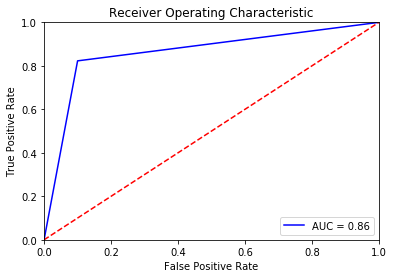

In [38]:
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Logistic Regression Model Precision-Recall Curve.

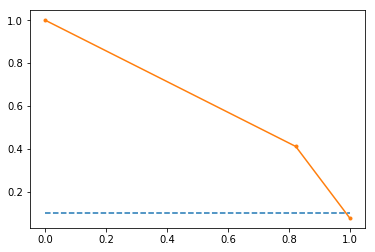

In [39]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, predictions)
auc = auc(recall, precision)
ap = average_precision_score(y_test, predictions)
plt.plot([0, 1], [0.1, 0.1], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show(True)

## Conclusion:

This is not a problem where `accuracy` is very important. In this problem, evaluation metrics like `True Negatives`, `Recall Score`, `ROC Curve` and `Precision-Recall Curve` are important.

Also, clearly, the business decisions should be made that it is not advised to give out loans in the state `IDAHO` and it is better to expand the bank loan in the `MIDWEST` region of the US.

The `Logistic Regresison` model performs the best in this case because of the probability values that it spits out. So, I considered this problem as a `Binary Classification` and performed modeling on it.

Please let me know if you have any questions regarding this notebook. I thoroughly enjoyed working on this problem and I really appreciate you considering me for the `Data Scientist` Position.